# Video Search Demo

This notebook demonstrates building a searchable video index using Pixeltable:
1. Extract audio from videos
2. Split audio into chunks for transcription
3. Break transcriptions into sentences for embedding-based search

## Pipeline Overview

**Base Table:** `skates`
- Stores videos
- Computed column: audio extracted from video

**View 1:** `audio_chunks`
- Splits audio into 15-second segments for transcription

**View 2:** `sentences` (to be added)
- Splits transcripts into sentences for semantic search

## Setup

  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached tokenizers-0.22.2-cp39-abi3-macosx_11_0_arm64.whl.metadata (7.3 kB)
  Using cached safetensors-0.7.0-cp38-abi3-macosx_11_0_arm64.whl.metadata (4.1 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached distro-1.9.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached sniffio-1.3.1-py3-none-any.whl.metadata (3.9 kB)
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Using cached wasabi-1.1.3-py3-none-any.whl.metadata (28 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached weasel-0.4.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached confection-0.1.5-py3-none-any.whl.metadata (19 kB)
  Using cached cloudpathlib-0.23.0-py3-none-any.whl.metadata (16 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached click-8.3.1-py3-none-any.w

In [2]:
import pixeltable as pxt
import pixeltable.functions as pxtf
import os
import getpass

In [3]:
# Set OpenAI API key if not already in environment
if 'OPENAI_API_KEY' not in os.environ:
    os.environ['OPENAI_API_KEY'] = getpass.getpass('Enter your OpenAI API key:')

In [ ]:
# Uncomment to clean working space
# pxt.drop_dir('olympics', force=True)

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/alison-pxt/.pixeltable/pgdata


In [5]:
pxt.create_dir('olympics')

Created directory 'olympics'.


## Base table

In [6]:
# Create a table with a video column
t = pxt.create_table('olympics.skates', schema={'video': pxt.Video}, if_exists='replace_force')

Created table 'skates'.


In [7]:
# Insert the videos if working locally
t.insert([
    {'video': 'media/olympics-glenn.mp4'},
    {'video': 'media/olympics-liu.mp4'},
    {'video': 'media/olympics-malinin.mp4'}
])

Inserted 3 rows with 0 errors in 0.08 s (38.13 rows/s)


3 rows inserted.

In [8]:
t

table 'olympics/skates'

 Column Name   Type Computed With
       video  Video

video
""
""
""

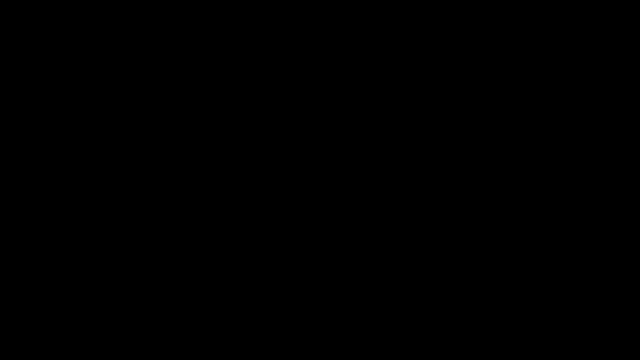
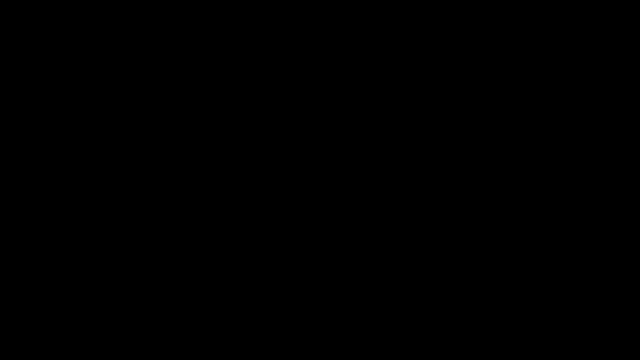
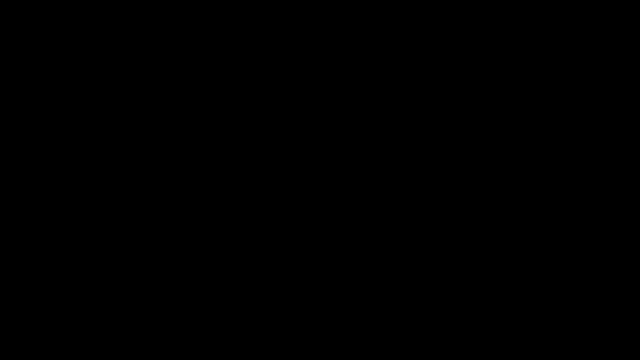

In [9]:
t.collect()

In [10]:
# get the audio file, save in a column
t.add_computed_column(audio=pxtf.video.extract_audio(t.video, format='wav'))

Added 3 column values with 0 errors in 1.19 s (2.52 rows/s)


3 rows updated.

In [11]:
t

table 'olympics/skates'

 Column Name   Type                       Computed With
       video  Video                                    
       audio  Audio  extract_audio(video, format='wav')

## View 1: Audio segments

In [12]:
ac_view = pxt.create_view(
    'olympics.audio_chunks',
    t,
    iterator=pxtf.audio.audio_splitter(
        audio=t.audio,
        chunk_duration_sec=15.0,
        overlap_sec=0.0
    ),
    if_exists='replace'
 )

In [13]:
ac_view

view 'olympics/audio_chunks' (of 'olympics/skates')

     Column Name             Type                       Computed With
             pos    Required[Int]                                    
  start_time_sec  Required[Float]                                    
    end_time_sec  Required[Float]                                    
     audio_chunk            Audio                                    
           video            Video                                    
           audio            Audio  extract_audio(video, format='wav')

In [14]:
ac_view.count()

94

In [15]:
ac_view.add_computed_column(
    transcript=pxtf.openai.transcriptions(
        ac_view.audio_chunk, model='whisper-1', model_kwargs={'language': 'en'}
    )
)

Added 94 column values with 0 errors in 15.90 s (5.91 rows/s)


94 rows updated.

In [16]:
# Extract text from transcript JSON and cast to a String
ac_view.add_computed_column(transcript_text=ac_view.transcript.text.astype(pxt.String))

Added 94 column values with 0 errors in 0.10 s (938.80 rows/s)


94 rows updated.

In [17]:
ac_view

view 'olympics/audio_chunks' (of 'olympics/skates')

      Column Name             Type                                      Computed With
              pos    Required[Int]                                                   
   start_time_sec  Required[Float]                                                   
     end_time_sec  Required[Float]                                                   
      audio_chunk            Audio                                                   
       transcript             Json  transcriptions(audio_chunk, model='whisper-1',...
  transcript_text           String                     transcript.text.astype(String)
            video            Video                                                   
            audio            Audio                 extract_audio(video, format='wav')

In [19]:
# show the transcript text
ac_view.select(ac_view.pos, ac_view.transcript_text).head()

pos,transcript_text
0,And she has bounced back so many times in her career.
1,"representing the United States of America, Amber Flynn. She said she wants that one performance, that one moment."
2,which can make her happy and take away from the Olympics here in Milan. Dan Richard watching.
3,"She has one of the most difficult free skates with a triple axel, only two women attempting. Very difficult element. Clean skate, she could make some moves, anything could happen."
4,can happen. Triple axels first.
5,That was one of the best triple axels I've ever seen from her.
6,"Difficult triple-triple here, triple-flip, triple-toe. ♪♪♪"
7,Each one of the seven jumping passes in this four minute free skate matters.
8,
9,Thank you for watching.


## View 2: Sentences


In [20]:
sent_view = pxt.create_view(
    'olympics.transcript_chunks',
    ac_view,
    iterator=pxtf.string.string_splitter(
        ac_view.transcript_text, separators='sentence'
    ),
    if_exists='replace'
)

pos,text,start_time_sec,end_time_sec,audio_chunk,transcript,transcript_text,video,audio
0,And she has bounced back so many times in her career.,0.,15.019,,"{""text"": ""And she has bounced back so many times in her career."", ""usage"": {""type"": ""duration"", ""seconds"": 16.}, ""logprobs"": null}",And she has bounced back so many times in her career.,,
0,"representing the United States of America, Amber Flynn.",15.,30.019,,"{""text"": ""representing the United States of America, Amber Flynn. She said she wants that one performance, that one moment."", ""usage"": {""type"": ""duration"", ""seconds"": 16.}, ""logprobs"": null}","representing the United States of America, Amber Flynn. She said she wants that one performance, that one moment.",,
1,"She said she wants that one performance, that one moment.",15.,30.019,,"{""text"": ""representing the United States of America, Amber Flynn. She said she wants that one performance, that one moment."", ""usage"": {""type"": ""duration"", ""seconds"": 16.}, ""logprobs"": null}","representing the United States of America, Amber Flynn. She said she wants that one performance, that one moment.",,

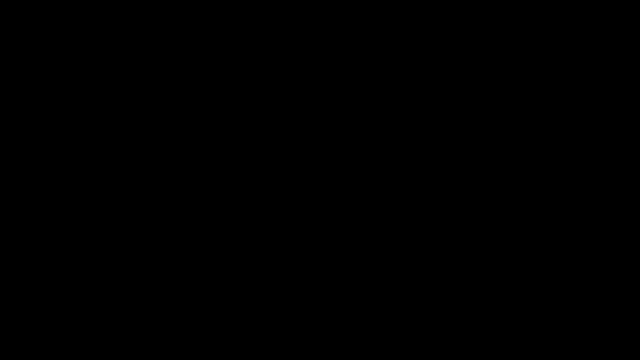
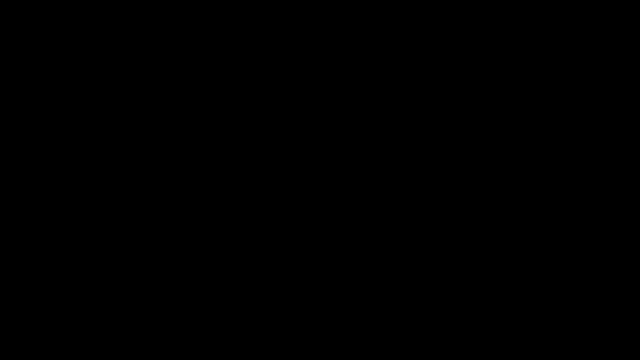
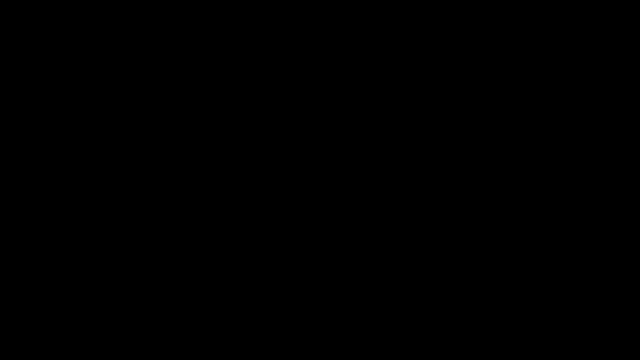

In [22]:
sent_view.head(3)

In [23]:
sent_view.add_embedding_index(
    sent_view.text,
    embedding=pxtf.huggingface.sentence_transformer.using(model_id='sentence-transformers/all-mpnet-base-v2')
)

In [24]:
sent_view

view 'olympics/transcript_chunks' (of 'olympics/audio_chunks', 'olympics/skates')

      Column Name              Type                                      Computed With
              pos     Required[Int]                                                   
             text  Required[String]                                                   
   start_time_sec   Required[Float]                                                   
     end_time_sec   Required[Float]                                                   
      audio_chunk             Audio                                                   
       transcript              Json  transcriptions(audio_chunk, model='whisper-1',...
  transcript_text            String                     transcript.text.astype(String)
            video             Video                                                   
            audio             Audio                 extract_audio(video, format='wav')

 Index Name Column  Metric                                          Embedding
       idx0   text  cosine  sentence_transformer(text, model_id='sentence-...